<a href="https://colab.research.google.com/github/guanyaohan/SRT/blob/master/Profiling_Self_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>Explore the Gemini API</h2>
  <p>The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.
  </p>
  <strong>How to get started</strong>
    <ol>
      <li>Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google account.</li>
      <li><a href="https://aistudio.google.com/app/apikey">Create an API key</a>.</li>
      <li>Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Prompting.ipynb">Python</a>, or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.</li>
      </ol>
  <strong>Explore use cases</strong>
    <ul>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb">Create a marketing campaign</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb">Analyze audio recordings</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/System_instructions.ipynb">Use System instructions in chat</a></li>
    </ul>
  <p>To learn more, check out the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.
  </p>
</div>


In [ ]:
!pip install memory_profiler

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


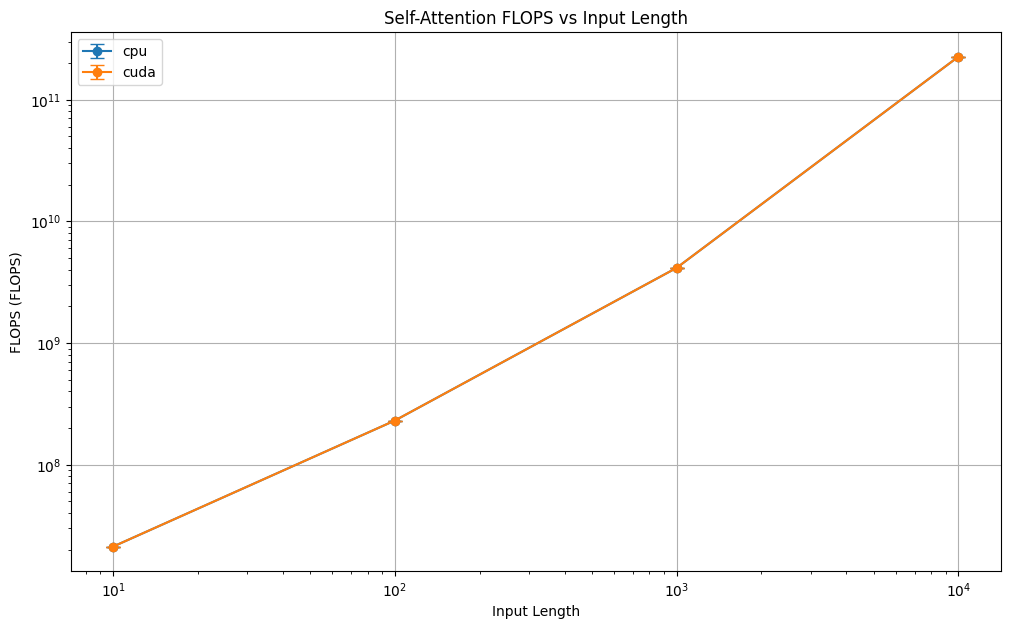

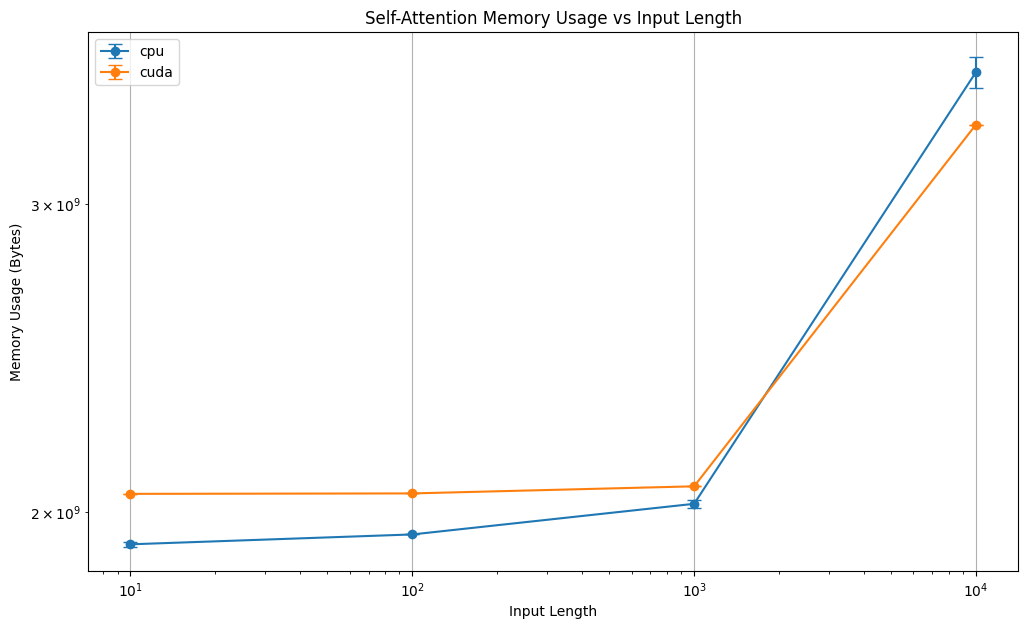

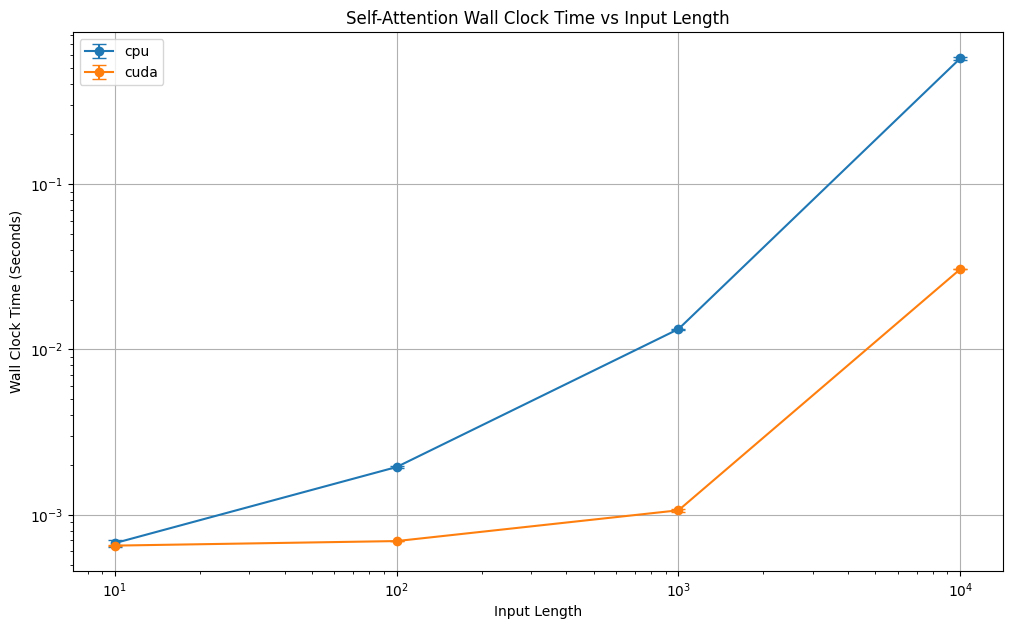

Profiling and plotting completed.


In [ ]:
# Install memory_profiler
!pip install memory_profiler

# Import necessary libraries
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity
from IPython.display import display, HTML
from memory_profiler import memory_usage
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

def run_model(model, input_tensor):
    model(input_tensor, input_tensor, input_tensor)

def profile_self_attention(input_length, embed_size=64, heads=1, device='cpu', num_runs=10):
    model = SelfAttention(embed_size, heads).to(device)
    input_tensor = torch.randn(1, input_length, embed_size).to(device)

    # Warm-up run
    model(input_tensor, input_tensor, input_tensor)

    # Measure wall clock time
    start_time = time.time()
    for _ in range(num_runs):
        model(input_tensor, input_tensor, input_tensor)
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs

    # Profile FLOPS
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                 record_shapes=True,
                 with_flops=True) as prof:
        model(input_tensor, input_tensor, input_tensor)

    events = prof.key_averages()
    flops = sum(event.flops for event in events if event.flops is not None)

    # Measure memory usage
    if device == 'cpu':
        mem_usage = memory_usage((run_model, (model, input_tensor)), max_usage=True)
        peak_memory = mem_usage * 1024 * 1024  # Convert MB to bytes
    else:  # CUDA device
        torch.cuda.reset_peak_memory_stats()  # Reset peak stats
        model(input_tensor, input_tensor, input_tensor)  # Run the model again
        peak_memory = torch.cuda.max_memory_allocated()  # Get peak memory usage

    return flops, peak_memory, avg_time

def run_experiments(input_lengths, devices):
    results = {device: {
        'flops': [], 'memory': [], 'time': [],
        'flops_error': [], 'memory_error': [], 'time_error': []
    } for device in devices}

    for device in devices:
        for length in input_lengths:
            flops_list, memory_list, time_list = [], [], []
            for _ in range(5):  # Run each experiment 5 times
                flops, memory, time = profile_self_attention(length, device=device)
                flops_list.append(float(flops))  # Convert to float
                memory_list.append(float(memory))  # Convert to float
                time_list.append(time)

            results[device]['flops'].append(sum(flops_list) / len(flops_list))
            results[device]['memory'].append(sum(memory_list) / len(memory_list))
            results[device]['time'].append(sum(time_list) / len(time_list))

            results[device]['flops_error'].append(torch.std(torch.tensor(flops_list, dtype=torch.float32)) / (len(flops_list)**0.5))
            results[device]['memory_error'].append(torch.std(torch.tensor(memory_list, dtype=torch.float32)) / (len(memory_list)**0.5))
            results[device]['time_error'].append(torch.std(torch.tensor(time_list, dtype=torch.float32)) / (len(time_list)**0.5))

    return results
def plot_results(results, input_lengths):
    metrics = ['FLOPS', 'Memory Usage', 'Wall Clock Time']
    keys = ['flops', 'memory', 'time']
    units = ['FLOPS', 'Bytes', 'Seconds']

    for i, metric in enumerate(keys):
        plt.figure(figsize=(12, 7))
        for device in results:
            plt.errorbar(input_lengths, results[device][metric],
                         yerr=results[device][f'{metric}_error'],
                         capsize=5, label=device, marker='o')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Input Length')
        plt.ylabel(f'{metrics[i]} ({units[i]})')
        plt.title(f'Self-Attention {metrics[i]} vs Input Length')
        plt.legend()
        plt.grid(True)
        plt.show()
# Main execution
input_lengths = [10, 100, 1000, 10000]
devices = ['cpu', 'cuda'] if torch.cuda.is_available() else ['cpu']

results = run_experiments(input_lengths, devices)
plot_results(results, input_lengths)

# Display a summary of the results
display(HTML("<h3>Summary of Results</h3>"))
for device in results:
    display(HTML(f"<h4>Device: {device}</h4>"))
    for metric in ['flops', 'memory', 'time']:
        display(HTML(f"<p><b>{metric.capitalize()}:</b></p>"))
        for length, value, error in zip(input_lengths, results[device][metric], results[device][f'{metric}_error']):
            display(HTML(f"<p>Input length {length}: {value:.2e} ± {error:.2e}</p>"))

print("Profiling and plotting completed.")